# Exploring $K_d$

In [1]:
# imports

from importlib import reload

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, time
import random 

import pandas
import seaborn as sns

from oceancolor.tara import io as tara_io
from oceancolor.ph import pigments
from oceancolor.hydrolight import loisel23
from oceancolor.utils import spectra
from oceancolor.utils import plotting

In [2]:
%matplotlib ipympl

# Load

In [6]:
reload(loisel23)
ds = loisel23.load_ds(4,0)
ds

<xarray.Dataset> Size: 18MB
Dimensions:  (Lambda: 81, IOP_Scenario: 3320)
Coordinates:
  * Lambda   (Lambda) float32 324B 350.0 355.0 360.0 365.0 ... 740.0 745.0 750.0
Dimensions without coordinates: IOP_Scenario
Data variables: (12/17)
    Rrs      (IOP_Scenario, Lambda) float32 1MB 0.01176 0.01201 ... 3.041e-05
    Ed_0+    (IOP_Scenario, Lambda) float32 1MB 0.7753 0.7314 ... 1.237 1.222
    Lw       (IOP_Scenario, Lambda) float32 1MB 0.009118 0.008785 ... 3.716e-05
    Lu_0+    (IOP_Scenario, Lambda) float32 1MB 0.04075 0.03903 ... 0.0624
    a        (IOP_Scenario, Lambda) float32 1MB 0.03096 0.02925 ... 2.83 2.85
    anw      (IOP_Scenario, Lambda) float32 1MB 0.02386 0.02245 ... 0.0004
    ...       ...
    bph      (IOP_Scenario, Lambda) float32 1MB 0.04521 0.04454 ... 0.1008
    bd       (IOP_Scenario, Lambda) float32 1MB 0.03323 0.03239 ... 0.03513
    bb       (IOP_Scenario, Lambda) float32 1MB 0.006968 0.006587 ... 0.001876
    bbnw     (IOP_Scenario, Lambda) float32 1MB 0.00105 0.001028 ... 0.001641
    bbph     (IOP_Scenario, Lambda) float32 1MB 0.0004521 0.0004454 ... 0.001008
    bbd      (IOP_Scenario, Lambda) float32 1MB 0.0005982 0.000583 ... 0.0006324

In [7]:
ds_profile = loisel23.load_ds(4,0, profile=True)
ds_profile

<xarray.Dataset> Size: 727MB
Dimensions:    (z: 61, Lambda: 81, IOP_Scenario: 3320)
Coordinates:
  * z          (z) float32 244B -1.0 0.0 0.1 0.2 0.3 ... 47.0 48.0 49.0 50.0
  * Lambda     (Lambda) float32 324B 350.0 355.0 360.0 ... 740.0 745.0 750.0
Dimensions without coordinates: IOP_Scenario
Data variables: (12/18)
    Rrs        (IOP_Scenario, Lambda) float32 1MB 0.01176 0.01201 ... 3.041e-05
    Ed_0+      (IOP_Scenario, Lambda) float32 1MB 0.7753 0.7314 ... 1.237 1.222
    Lw         (IOP_Scenario, Lambda) float32 1MB 0.009118 ... 3.716e-05
    Lu_0+      (IOP_Scenario, Lambda) float32 1MB 0.04075 0.03903 ... 0.0624
    zeu_PAR    (IOP_Scenario) float32 13kB 999.0 999.0 999.0 ... 999.0 999.0
    z1_PAR     (IOP_Scenario) float32 13kB 15.27 15.37 13.4 ... 11.05 10.27
    ...         ...
    Eu_z       (z, IOP_Scenario, Lambda) float32 66MB 0.05486 ... 1.648e-09
    KEu_z      (z, IOP_Scenario, Lambda) float32 66MB nan nan ... 0.1221 0.1133
    KEd_z      (z, IOP_Scenario, Lambda) float32 66MB nan nan ... 0.1245 0.1167
    KLu_z      (z, IOP_Scenario, Lambda) float32 66MB nan nan ... 0.127 0.1195
    md_z       (z, IOP_Scenario, Lambda) float32 66MB 0.7305 0.7361 ... 0.5266
    mu_z       (z, IOP_Scenario, Lambda) float32 66MB 0.3966 0.4011 ... 0.5196

In [9]:
ds_profile.z

<xarray.DataArray 'z' (z: 61)> Size: 244B
array([-1. ,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. , 11. , 12. , 13. ,
       14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. , 22. , 23. , 24. , 25. ,
       26. , 27. , 28. , 29. , 30. , 31. , 32. , 33. , 34. , 35. , 36. , 37. ,
       38. , 39. , 40. , 41. , 42. , 43. , 44. , 45. , 46. , 47. , 48. , 49. ,
       50. ], dtype=float32)
Coordinates:
  * z        (z) float32 244B -1.0 0.0 0.1 0.2 0.3 ... 46.0 47.0 48.0 49.0 50.0

In [12]:
ds_profile.KEd_z[1,:,:].shape

(3320, 81)

## Unpack for convenience

In [27]:
wave = ds.Lambda.data
Rrs = ds.Rrs.data
Kd = ds_profile.KEd_z[1,:,:]
a = ds.a.data
aph = ds.aph.data
bb = ds.bb.data

# Wavelengths

In [14]:
i370 = np.argmin(np.abs(wave-370.))
i440 = np.argmin(np.abs(wave-440.))
i500 = np.argmin(np.abs(wave-500.))
i600 = np.argmin(np.abs(wave-600.))

# Chl

In [28]:
Chl = aph[:,i440] / 0.05582

In [18]:
def lee2002_func(a, bb, thetas=0.):
    Kd_lee = (1+0.005*thetas)*a + 4.18 * (1-0.52*np.exp(-10.8*a))*bb
    return Kd_lee

# Plots

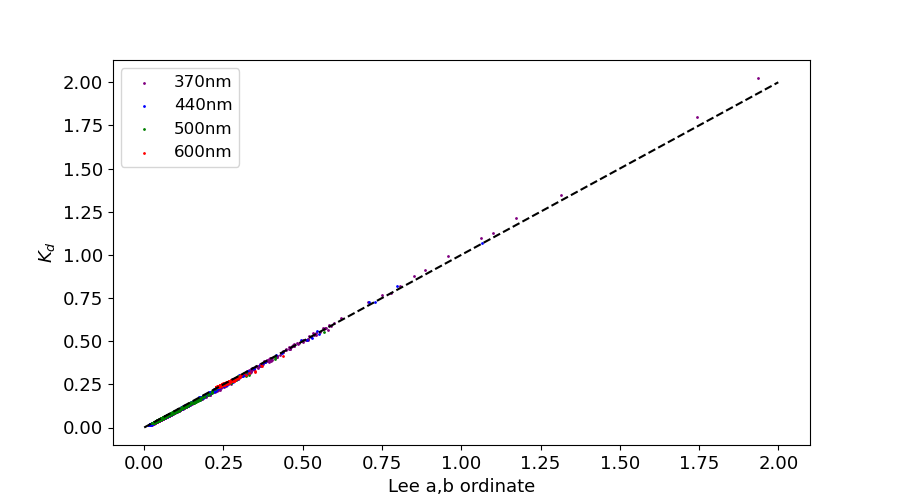

In [21]:
#
fig = plt.figure(figsize=(9,5))

plt.clf()
ax = plt.gca()
for lbl, clr, idx in zip(['370nm', '440nm', '500nm', '600nm'],
                              ['purple', 'b','g', 'r'],
                              [i370, i440, i500, i600]):
    xscat = a[:,idx] + 4.18 * (1-0.52*np.exp(-10.8*a[:,idx]))*bb[:,idx]
    ax.scatter(xscat, Kd[:,idx], color=clr, s=1., label=lbl)
    #irrs = rrs_func(u[:,idx], ans[0], ans[1])
    #usrt = np.argsort(u[:,idx])
    #ax.plot(u[usrt,idx], irrs[usrt], '-', color=clr, label=f'Fit: G0={ans[0]:0.2f}, G1={ans[1]:0.2f}')
ax.plot([0., 2.], [0., 2.], 'k--')
#
ax.set_xlabel('Lee a,b ordinate')
ax.set_ylabel(r'$K_d$')
ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
plt.show()

## $R_{\rm rs}$

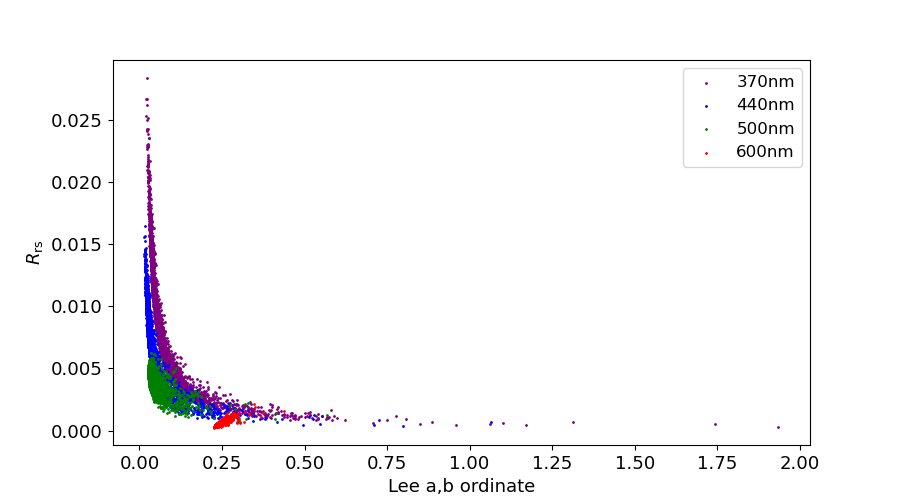

In [23]:
#
fig = plt.figure(figsize=(9,5))

plt.clf()
ax = plt.gca()
for lbl, clr, idx in zip(['370nm', '440nm', '500nm', '600nm'],
                              ['purple', 'b','g', 'r'],
                              [i370, i440, i500, i600]):
    xscat = a[:,idx] + 4.18 * (1-0.52*np.exp(-10.8*a[:,idx]))*bb[:,idx]
    ax.scatter(xscat, Rrs[:,idx], color=clr, s=1., label=lbl)
    #irrs = rrs_func(u[:,idx], ans[0], ans[1])
    #usrt = np.argsort(u[:,idx])
    #ax.plot(u[usrt,idx], irrs[usrt], '-', color=clr, label=f'Fit: G0={ans[0]:0.2f}, G1={ans[1]:0.2f}')
#ax.plot([0., 2.], [0., 2.], 'k--')
#
ax.set_xlabel('Lee a,b ordinate')
ax.set_ylabel(r'$R_{\rm rs}$')
ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
plt.show()

----

# Find two $R_{\rm rs}$ (and hopefully Chl) close to one another

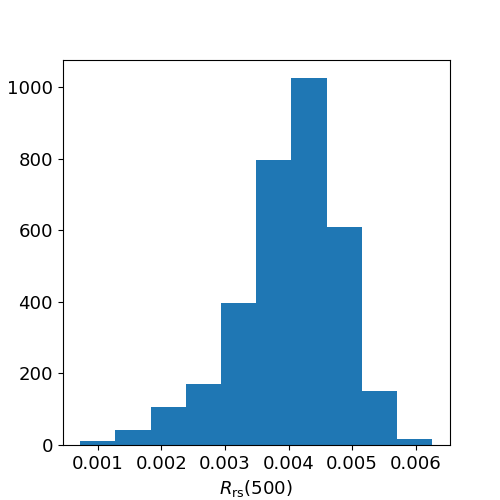

In [37]:
#
fig = plt.figure(figsize=(5,5))

plt.clf()
ax = plt.gca()
ax.hist(Rrs[:,i500])
#
ax.set_xlabel(r'$R_{\rm rs}(500)$')
#ax.set_ylabel(r'$R_{\rm rs}$')
#ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
plt.show()

## Close in $R_{\rm rs}$

In [26]:
closeRrs = np.abs(Rrs[:,i500] - 0.004) < 5e-5
np.sum(closeRrs)

183

## Chl

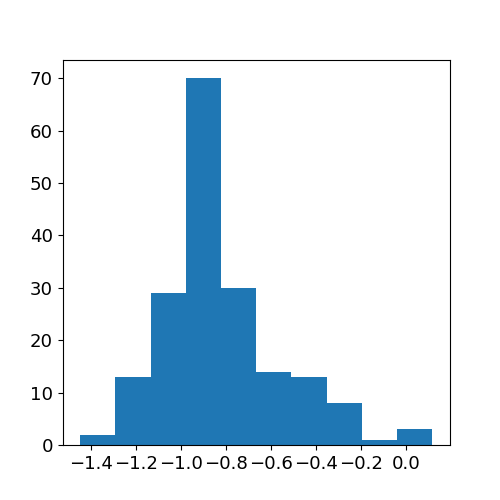

In [30]:
#
fig = plt.figure(figsize=(5,5))

plt.clf()
ax = plt.gca()
ax.hist(np.log10(Chl[closeRrs]))
#
#ax.set_xlabel('Lee a,b ordinate')
#ax.set_ylabel(r'$R_{\rm rs}$')
#ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
plt.show()

In [31]:
closeChl = np.abs(Chl - 0.15) < 0.01

In [33]:
close = closeRrs & closeChl
np.sum(close)

20

In [34]:
a[close, i500]

array([0.035793, 0.033568, 0.032686, 0.030586, 0.027106, 0.033738,
       0.031971, 0.034242, 0.029024, 0.029042, 0.030143, 0.029193,
       0.027375, 0.030989, 0.029152, 0.031381, 0.030895, 0.03244 ,
       0.032278, 0.028324], dtype=float32)

In [35]:
i_close = np.where(close)[0]
a[i_close[0], i500]

0.035793

In [38]:
i_high = i_close[0]
i_low = i_close[-1]
i_low, i_high

(3073, 82)

## Fractional changes

In [41]:
dR = np.abs(Rrs[i_low,i500] - Rrs[i_high,i500]) / Rrs[i_low,i500]
dR

0.019202314

In [43]:
dChl = np.abs(Chl[i_low] - Chl[i_high]) / Chl[i_low]
dChl

0.004380143

In [45]:
da = np.abs(a[i_low,i500] - a[i_high,i500]) / a[i_low,i500]
da

0.26369858

## Let's plot $a$

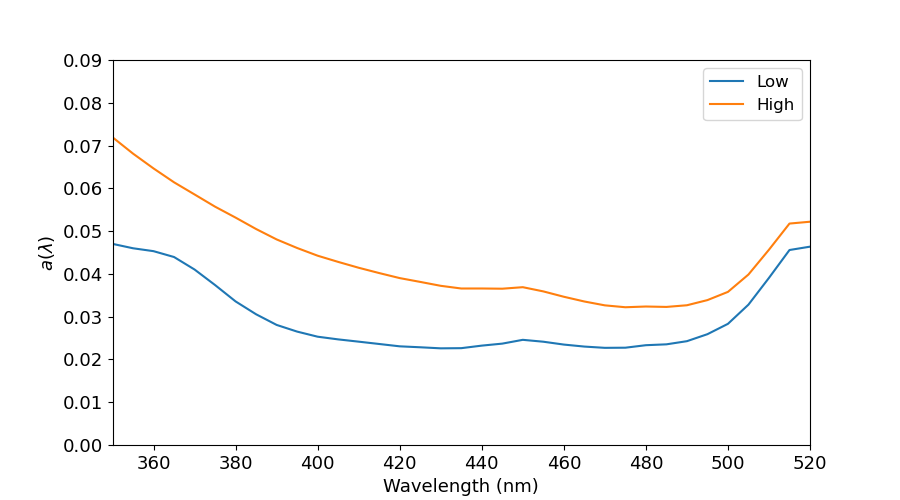

In [48]:
#
fig = plt.figure(figsize=(9,5))

plt.clf()
ax = plt.gca()
ax.plot(wave, a[i_low], label='Low')
ax.plot(wave, a[i_high], label='High')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$a(\lambda)$')
ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
ax.set_xlim(350., 520.)
ax.set_ylim(0., 0.09)
#
plt.show()

## And $R_{\rm rs}$

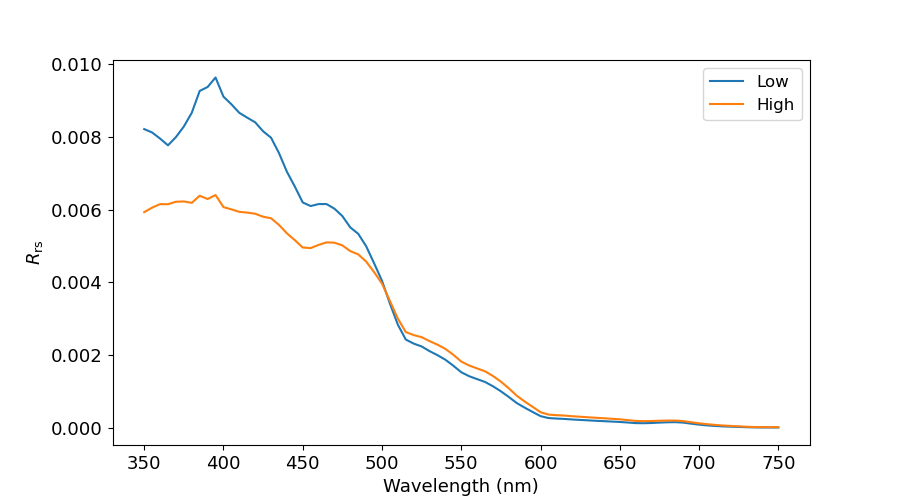

In [52]:
fig = plt.figure(figsize=(9,5))

plt.clf()
ax = plt.gca()
ax.plot(wave, Rrs[i_low], label='Low')
ax.plot(wave, Rrs[i_high], label='High')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$R_{\rm rs}$')
ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
#ax.set_xlim(350., 520.)
#ax.set_ylim(0., 0.012)
#
plt.show()

----

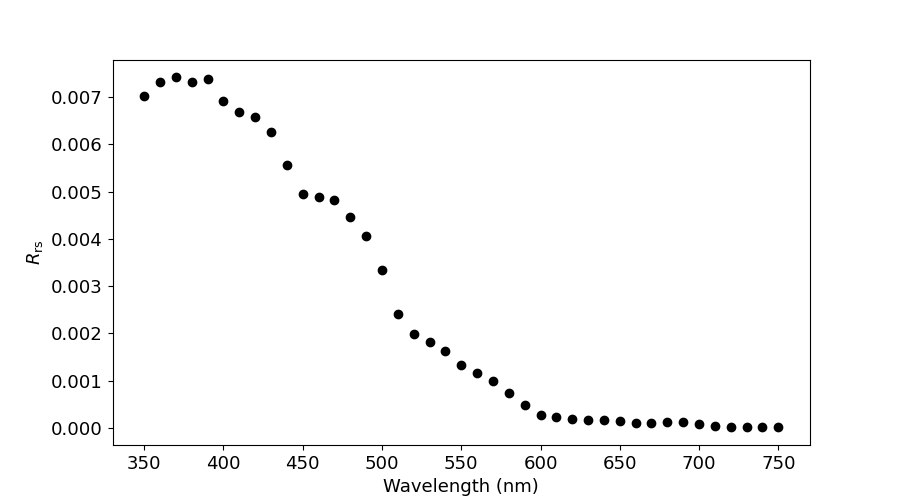

In [54]:
fig = plt.figure(figsize=(9,5))

plt.clf()
ax = plt.gca()
ax.plot(wave[::2], Rrs[170][::2], 'ko')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$R_{\rm rs}$')
#ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
#ax.set_xlim(350., 520.)
#ax.set_ylim(0., 0.012)
#
plt.show()

In [55]:
ds

<xarray.Dataset> Size: 18MB
Dimensions:  (Lambda: 81, IOP_Scenario: 3320)
Coordinates:
  * Lambda   (Lambda) float32 324B 350.0 355.0 360.0 365.0 ... 740.0 745.0 750.0
Dimensions without coordinates: IOP_Scenario
Data variables: (12/17)
    Rrs      (IOP_Scenario, Lambda) float32 1MB 0.01176 0.01201 ... 3.041e-05
    Ed_0+    (IOP_Scenario, Lambda) float32 1MB 0.7753 0.7314 ... 1.237 1.222
    Lw       (IOP_Scenario, Lambda) float32 1MB 0.009118 0.008785 ... 3.716e-05
    Lu_0+    (IOP_Scenario, Lambda) float32 1MB 0.04075 0.03903 ... 0.0624
    a        (IOP_Scenario, Lambda) float32 1MB 0.03096 0.02925 ... 2.83 2.85
    anw      (IOP_Scenario, Lambda) float32 1MB 0.02386 0.02245 ... 0.0004
    ...       ...
    bph      (IOP_Scenario, Lambda) float32 1MB 0.04521 0.04454 ... 0.1008
    bd       (IOP_Scenario, Lambda) float32 1MB 0.03323 0.03239 ... 0.03513
    bb       (IOP_Scenario, Lambda) float32 1MB 0.006968 0.006587 ... 0.001876
    bbnw     (IOP_Scenario, Lambda) float32 1MB 0.00105 0.001028 ... 0.001641
    bbph     (IOP_Scenario, Lambda) float32 1MB 0.0004521 0.0004454 ... 0.001008
    bbd      (IOP_Scenario, Lambda) float32 1MB 0.0005982 0.000583 ... 0.0006324

In [56]:
ds.bnw[0,:] / ds.bbnw[0,:] 

<xarray.DataArray (Lambda: 81)> Size: 324B
array([74.68393 , 74.79969 , 74.92705 , 74.9167  , 75.0378  , 75.124626,
       75.13752 , 75.209496, 75.278244, 75.341965, 75.39175 , 75.43892 ,
       75.465126, 75.50207 , 75.54204 , 75.575615, 75.60349 , 75.63851 ,
       75.72144 , 75.81717 , 75.91891 , 76.00567 , 76.09044 , 76.18736 ,
       76.28247 , 76.37781 , 76.46424 , 76.56188 , 76.68742 , 76.81159 ,
       76.977135, 77.115845, 77.24037 , 77.37062 , 77.470856, 77.57193 ,
       77.66626 , 77.757835, 77.83771 , 77.91961 , 77.986565, 78.07419 ,
       78.13271 , 78.20386 , 78.25616 , 78.310776, 78.371925, 78.4116  ,
       78.46681 , 78.52625 , 78.58857 , 78.63778 , 78.682434, 78.7248  ,
       78.76995 , 78.821785, 78.86352 , 78.90608 , 78.954834, 78.992584,
       79.03227 , 79.05867 , 79.04409 , 79.00584 , 78.947105, 78.96276 ,
       79.07005 , 79.27704 , 79.464386, 79.59217 , 79.66678 , 79.73432 ,
       79.787605, 79.83689 , 79.86918 , 79.91821 , 79.971855, 80.02041 ,
       80.062614, 80.105446, 80.14059 ], dtype=float32)
Coordinates:
  * Lambda   (Lambda) float32 324B 350.0 355.0 360.0 365.0 ... 740.0 745.0 750.0